In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os
os.chdir("C:\\code\\activ")

In [3]:
df_name = 'nov_nine_var.xlsx'

In [20]:
df = pd.read_excel('./documents/' + df_name).iloc[:,1::]
X = df.iloc[:,0:21].to_numpy()
y = df.iloc[:,-1].to_numpy()

In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [6]:
ACTION_NUM = 5

In [7]:
def make_dataset(X, length=12, n=100, test_size=0.2):
    X_data, y_data = [], []

    for i in range(int(n*1.2)):
        idx = rand.randint(0, len(X)-length-2)
        X_data.append(X[idx:idx+length])
        y_data.append(X[idx+length+1])

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return train_test_split(X_data, y_data, test_size=test_size, shuffle=False)

In [8]:
d = []
for i in range(ACTION_NUM):
    d.append(make_dataset(X))

In [9]:
class model_(tf.keras.Model):
    def __init__(self):
        super(model_, self).__init__()
        self.d0 = tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True, dropout=0.2)
        self.d1 = tf.keras.layers.LSTM(64, activation='tanh', return_sequences=False)
        self.d2 = tf.keras.layers.Dense(64, activation='relu')
        self.d3 = tf.keras.layers.Dense(units=21, activation='linear')

    def call(self, inputs):
        x = self.d0(inputs)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)

        return x

In [10]:
model_0 = model_()
model_1 = model_()
model_2 = model_()
model_3 = model_()
model_4 = model_()

In [11]:
model_list = [model_0, model_1, model_2, model_3, model_4]

In [12]:
for i in range(5):
    model_list[i].build(input_shape=(1, 12, 21))
    model_list[i].compile(optimizer='adam', loss='mse')

In [13]:
for i, model in enumerate(model_list):
    X_train, X_test, y_train, y_test = d[i][0], d[i][1], d[i][2], d[i][3]
    hist = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [14]:
for i in range(5):
    model_list[i].save('./model/action_net{0}'.format(i))
    print(i)

INFO:tensorflow:Assets written to: ./model/action_net0\assets


INFO:tensorflow:Assets written to: ./model/action_net0\assets


0


INFO:tensorflow:Assets written to: ./model/action_net1\assets


INFO:tensorflow:Assets written to: ./model/action_net1\assets


1


INFO:tensorflow:Assets written to: ./model/action_net2\assets


INFO:tensorflow:Assets written to: ./model/action_net2\assets


2


INFO:tensorflow:Assets written to: ./model/action_net3\assets


INFO:tensorflow:Assets written to: ./model/action_net3\assets


3


INFO:tensorflow:Assets written to: ./model/action_net4\assets


INFO:tensorflow:Assets written to: ./model/action_net4\assets


4


In [15]:
dnn = tf.keras.models.load_model('./model/dnn.h5')

In [19]:
b = []
for i in range(0, len(X)-12):
    b.append(X[i:i+12])
b = np.array(b).reshape(len(b), 12, 21)

c_list = ['b', 'g', 'r', 'y', 'm']

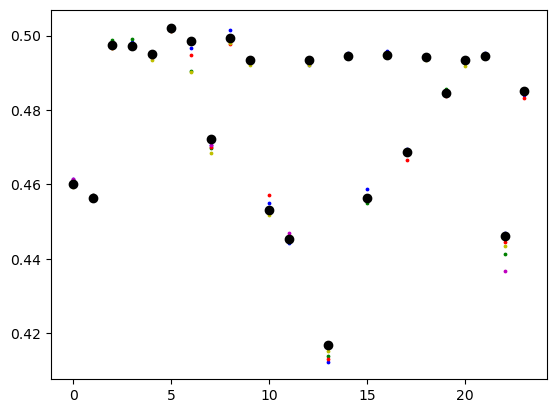

In [17]:
l_x_shaft = [i for i in range(len(X_test))]

for i in range(5):
    plt.scatter(l_x_shaft, dnn.predict(model_list[i](X_test), verbose=0), c=c_list[i], s=3)

plt.scatter(l_x_shaft, dnn.predict(y_test, verbose=0), c='black')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (419,) and (431,)

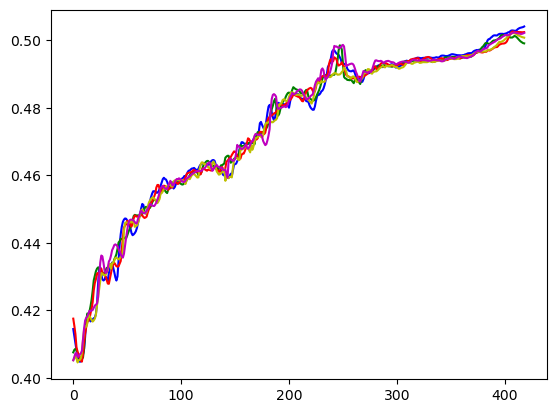

In [21]:
l_x_shaft = [i for i in range(len(b))]

for i in range(5):
    plt.plot(l_x_shaft, dnn.predict(model_list[i](b), verbose=0), c=c_list[i])

plt.plot(y, c='black')
plt.show()

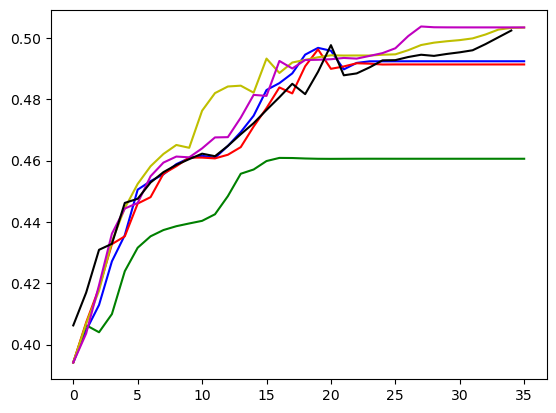

In [ ]:
for j in range(ACTION_NUM):
    pred = X[0:12].reshape(1, 12, 21)
    for i in range(410):
        pred = np.append(pred, model_list[j].predict(pred[0, i:i+12].reshape(1, 12, 21), verbose=0).reshape(1, 1, 21)).reshape(1, 13+i, 21)
    c = dnn.predict(pred.reshape(pred.shape[1], 21), verbose=0)

    l = []
    for i in range(0, 422, 12):
        l.append(c[i])

    plt.plot(l, c=c_list[j])
plt.plot(y, c='black')
plt.show()